# Generating exploratory medias

In [1]:
# Import libs
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from collections import Counter

In [2]:
# Reading dataset
base = pd.read_csv("train/train.csv")

In [3]:
# Visualizing dataset
base.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
# Printing how many rows (observations) the dataset has
print(f"The dataset has {base.shape[0]} observations.")
# Generating auxiliar column that represent how any words have in each phrase
base['text_len'] = base['text'].apply(lambda x: len(x.split()))
print(f"The mean words in texts is {base['text_len'].mean()}, with minimum of {base['text_len'].min()} words \
and maximum of {base['text_len'].max()} words")

The dataset has 19579 observations.
The mean words in texts is 26.730476530977068, with minimum of 2 words and maximum of 861 words


![image](figure1_frequency_author.png)

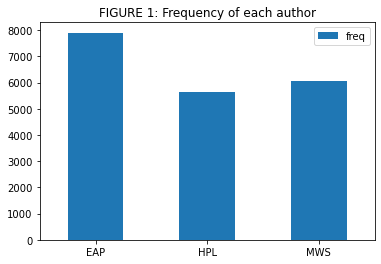

In [28]:
base['freq'] = 1
count_per_author = base.groupby('author').agg({'freq': 'count'}).reset_index()
count_per_author.plot(kind='bar')
plt.title('FIGURE 1: Frequency of each author')
plt.xticks(np.arange(3), count_per_author['author'], rotation = 0)
plt.savefig("figure1_frequency_author.png", dpi= 100)
plt.show()

In [33]:
def cloud(text, title):
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(8.0,8.0)    #(6.0,4.0)
    #mpl.rcParams['font.size']=12                #10 
    mpl.rcParams['savefig.dpi']=100             #72 
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    stopwords = set(STOPWORDS) # Redundant
    wordcloud = WordCloud(width=460, height=460,
                          background_color='white',
                          stopwords=stopwords,
                         ).generate(" ".join(text))
    
    # Output Visualization
    
    plt.figure(figsize=(10,5), facecolor='w')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=50,color='k')
    plt.savefig(f"wordcloud_{title}", dpi=100)

None


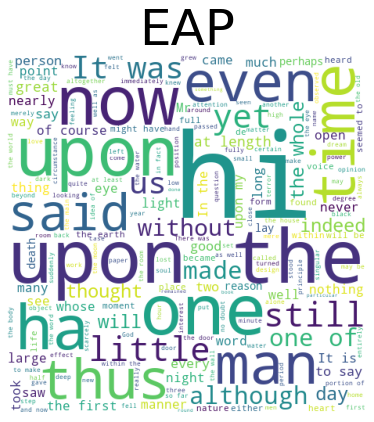

In [34]:
x = 'EAP'
print(cloud(base[base.author == x]['text'].values,x))

None


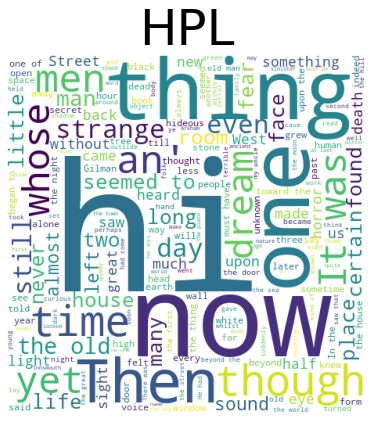

In [35]:
x = 'HPL'
print(cloud(base[base.author == x]['text'].values,x))

None


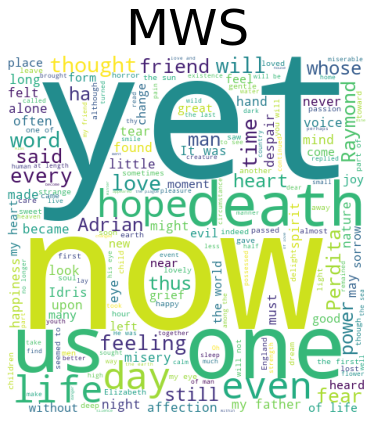

In [36]:
x = 'MWS'
print(cloud(base[base.author == x]['text'].values,x))

# Generating model medias

In [14]:
VOCAB_SIZE = 44900
CONTEXT_SIZE = 5
BATCH_SIZE = 256
LR = 8e-3
HIDDEN_DIM = 128
EMBEDDING_DIM = 50

In [22]:
import pickle
with open('../dev/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

with open('../dev/vocab_t.pkl', 'rb') as f:
    vocab_t = pickle.load(f)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import collections
import itertools
import random
import torch

from transformers import GPT2LMHeadModel, GPT2Tokenizer

import torch.nn as nn

import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from sklearn. model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [24]:
# Setting up seeds
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [25]:
# Defining our model and de decoder function
class BengioLModel(nn.Module):

    def __init__(self, vocab_size , embedding_dim = 128, hidden_size = 500, context_size = 5):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)

        self.context_size = context_size
        self.embedding_dim = embedding_dim

    def forward(self, x):
        # Ref: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
        x = self.embedding_layer(x).view(-1,self.context_size*self.embedding_dim)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x
    
    def embedding(self, x):
        x = self.embedding_layer(x).view(-1,self.context_size*self.embedding_dim)
        x = self.linear1(x)
        
        return x
    
def decode_model(logits, k = 10, p = 0.95, method='greedy'):
    
    if(method=='greedy'):
        
        selected_tokens_ids = torch.argmax(model(test)).unsqueeze(dim=0).unsqueeze(dim=0)
        
    elif(method=='topk'):
        # Pegamos os valores e índices do top-10 logitos
        values, idxs = logits.topk(k)

        # Selecionamos um elemento aleatório de cada elemento do batch com o multinomial + softmax
        selected_idx = F.softmax(values, dim=-1).type(torch.float).multinomial(1)

        # Aplicamos o vetor de índices no vetor de token_ids e geramos os tokens selecionados
        selected_tokens_ids = idxs.gather(-1, selected_idx)
    elif(method=='ns'):
        # Ordenamos os logitos em ordem decrescente
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        # Geramos probabilidade acumulada pois dai é mais fácil selecionar o ponto de corte (.95)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        # Gera vetor auxiliar que guardará os tokens ids
        selected_tokens_ids = torch.zeros((1, 1), dtype=torch.long, device=logits.device)
        # Para cada elemento do batch
        
        # Selecionamos os logitos onde o vetor acumulado ainda é menor que 0.95
        filtered = sorted_logits[cumulative_probs<p]
        # Se não tiver nenhum logito com cumprob <0.95, retornamos aquele com o logito mais alto
        if(len(filtered) == 0):
            selected_tokens_ids[0] = sorted_indices[0].unsqueeze(dim=0)
        # Se não for vazio, então:
        else:
            # Aplicamos softmax nos logitos filtrados
            filtered = F.softmax(filtered, dim = -1)
            # Selecionamos os tokens ids selecionados, amostrando um dos logitos filtrados e selecionando o mesmo índice
            # dos tokens ids ordenados
#             print(filtered, sorted_indices)
            selected_tokens_ids = sorted_indices[cumulative_probs<p].gather(-1, F.softmax(filtered, dim=-1).multinomial(1)).unsqueeze(dim=0)
        
    return selected_tokens_ids

In [26]:
## Intanciando modelo, otimizador e função de perda

# Model
model = BengioLModel(vocab_size = VOCAB_SIZE , embedding_dim = EMBEDDING_DIM, hidden_size = HIDDEN_DIM, context_size = CONTEXT_SIZE).to(device)

model.load_state_dict(torch.load('../dev/fixed_stuff/model_20_epochs.pt'))

model.eval()

# Otimizador
opt = torch.optim.SGD(model.parameters(), LR)
# Função de perda
loss_func = torch.nn.CrossEntropyLoss()

In [27]:
## Visualizando o modelo em 10 iterações de geração de texto
torch.manual_seed(42)
test = 'EAP once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())

test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)

next_token = torch.argmax(model(test))

vocab_t[int(next_token)]

EAP_token = torch.tensor([44897]).to(device)
MWS_token = torch.tensor([44898]).to(device)
HPL_token = torch.tensor([44899]).to(device)

# print(EAP_token)

N = 10

print("Edgar Allan Poe")
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([EAP_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

print("Marry Shelley")
test = 'MWS once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())
test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([MWS_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

print("HP Lovecraft")
test = 'HPL once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())
test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([HPL_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

Edgar Allan Poe
EAP once upon a time respite ermined unaltered, offered. elementary nuts, counts, validity use. torture



Marry Shelley
MWS once upon a time household lomond attribute thumb." cambridge, experienced. nations? countess 'snob' agile,



HP Lovecraft
HPL once upon a time flash moderate. patients," galleons. saucers super stores, intricate blush. puzzled,



